## Advanced Lane Finding 

The goals of this project is find road lane lines in a video stream and overlay the lines with a computed polynomial curve. 
In order to achieve this goal, methods and classes were built to do the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients (Sobel), to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

This jupyter notebook breaks down all the steps and display the output from each step. There is a separate pipeline written in notebook that combines all the steps with the same configuration and applies averaging techniques for the test video.

In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import glob
import math
from skimage.feature import corner_harris,corner_peaks
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%matplotlib inline


## Performing camera calibration 

Camera calibration is performed in order to correct the deformation in the images that is caused to the optic lens curvature. The first step is to print a chessboard and take random pictures of it. Then count the chess intersecting squires to provide "objp" which holds the (x,y,z) coordinates of these corners. Z=0 here and the object points are the same for all images in the calibration folder. The objpoints will be appended in "objp"  every time the method successfully detect all chessboard corners in a test image. "imgpoints" will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

"objpoints" and "imgpoints" were used to compute the camera calibration and distortion coefficients using the "cv2.calibrateCamera()" function on a test image in "cv2.undistort()" 

In [25]:
# prepare object points. The number of corners are 6x9
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images, all located in camera_cal
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # imread reads images in BGR format
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
cv2.destroyAllWindows()

## Perform distortion removal on test images 
### 1. Has the distortion correction been correctly applied to each image?

Undistortion is performed on the provided test images before they are used in the pipeline. This also applies to the video frames. "dst" holds undistorted frames from "cv2.undistort" that were computed using "mtx".

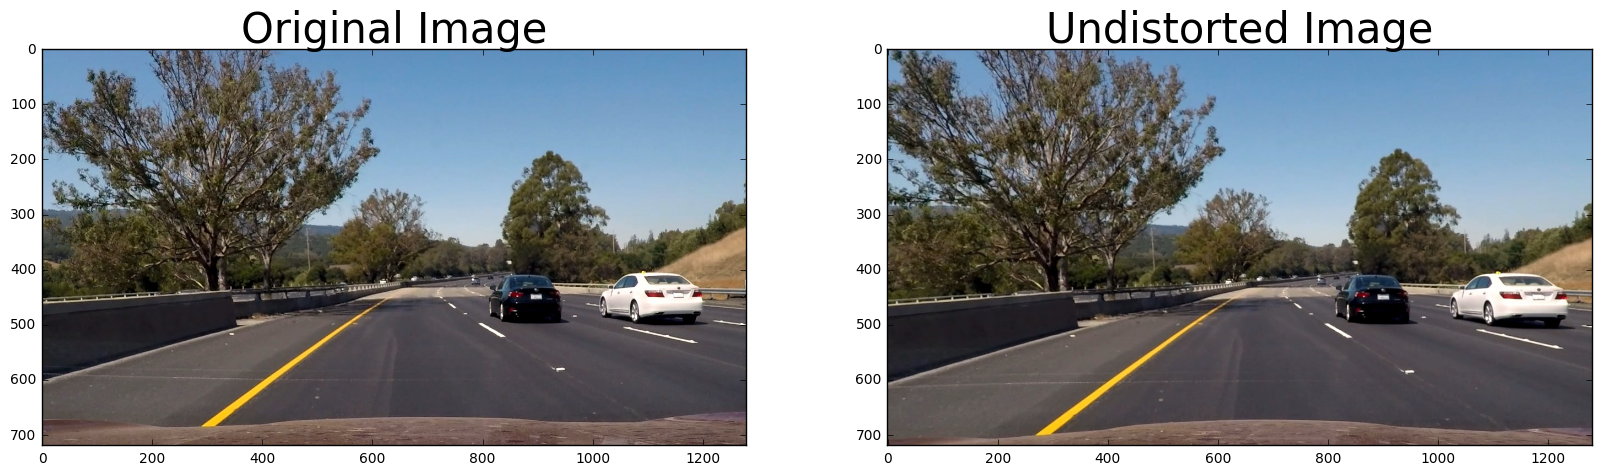

In [37]:
#Implement calibration on the images that will be used
import pickle
# Test undistortion on an image
img = cv2.imread('test_images/Distorted/test6.jpg')
img_size = (img.shape[1], img.shape[0])
#img = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
#dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
cv2.imwrite('test_images/test6.jpg',dst)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
img_RGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img_RGB)
ax1.set_title('Original Image', fontsize=30)
dst_RGB=cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
ax2.imshow(dst_RGB)
ax2.set_title('Undistorted Image', fontsize=30)

## Image preprocessing and filtering
### 2. Has a binary image been created using color transforms, gradients or other methods?
Before finding the lane lines in the images, it's very important to perform further preprocessing. It's also helpful to take advantage of some properties found in 3 channel images such as color segmentation. I've tested 6 image filtering methods

1- Gaussian blurring

2- Gradients threshold

3- RGB splitting and thresholding

4- HLS splitting and thresholding

5- Magnitude thresholding

6- Edge detection (Sobel)

1- "cv2.GaussianBlur"  was applied to smooth all images and the images where converted to gray scale using "cv2.COLOR_RGB2GRAY". 
2- The thresholded binary image is finally shown in the figures below. Several thresholding ranges were tested and finally I determined that the range "thresh = (190, 255)" is bust suited for these images.

In [38]:
def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def transform(img):
    imshape = img.shape
    img_size = (img.shape[1], img.shape[0])
    src=np.float32([[160,imshape[0]],[imshape[1]/2-60, imshape[0]/2+90],[imshape[1]/2+100, imshape[0]/2+90], [imshape[1]-20,imshape[0]]])
    dst=np.float32([[(240,imshape[0]),(240, 0),(imshape[1]-130, 0), (imshape[1]-130,imshape[0])]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    wraped =  cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)
    
    return  Minv, wraped


(720, 1280, 3)


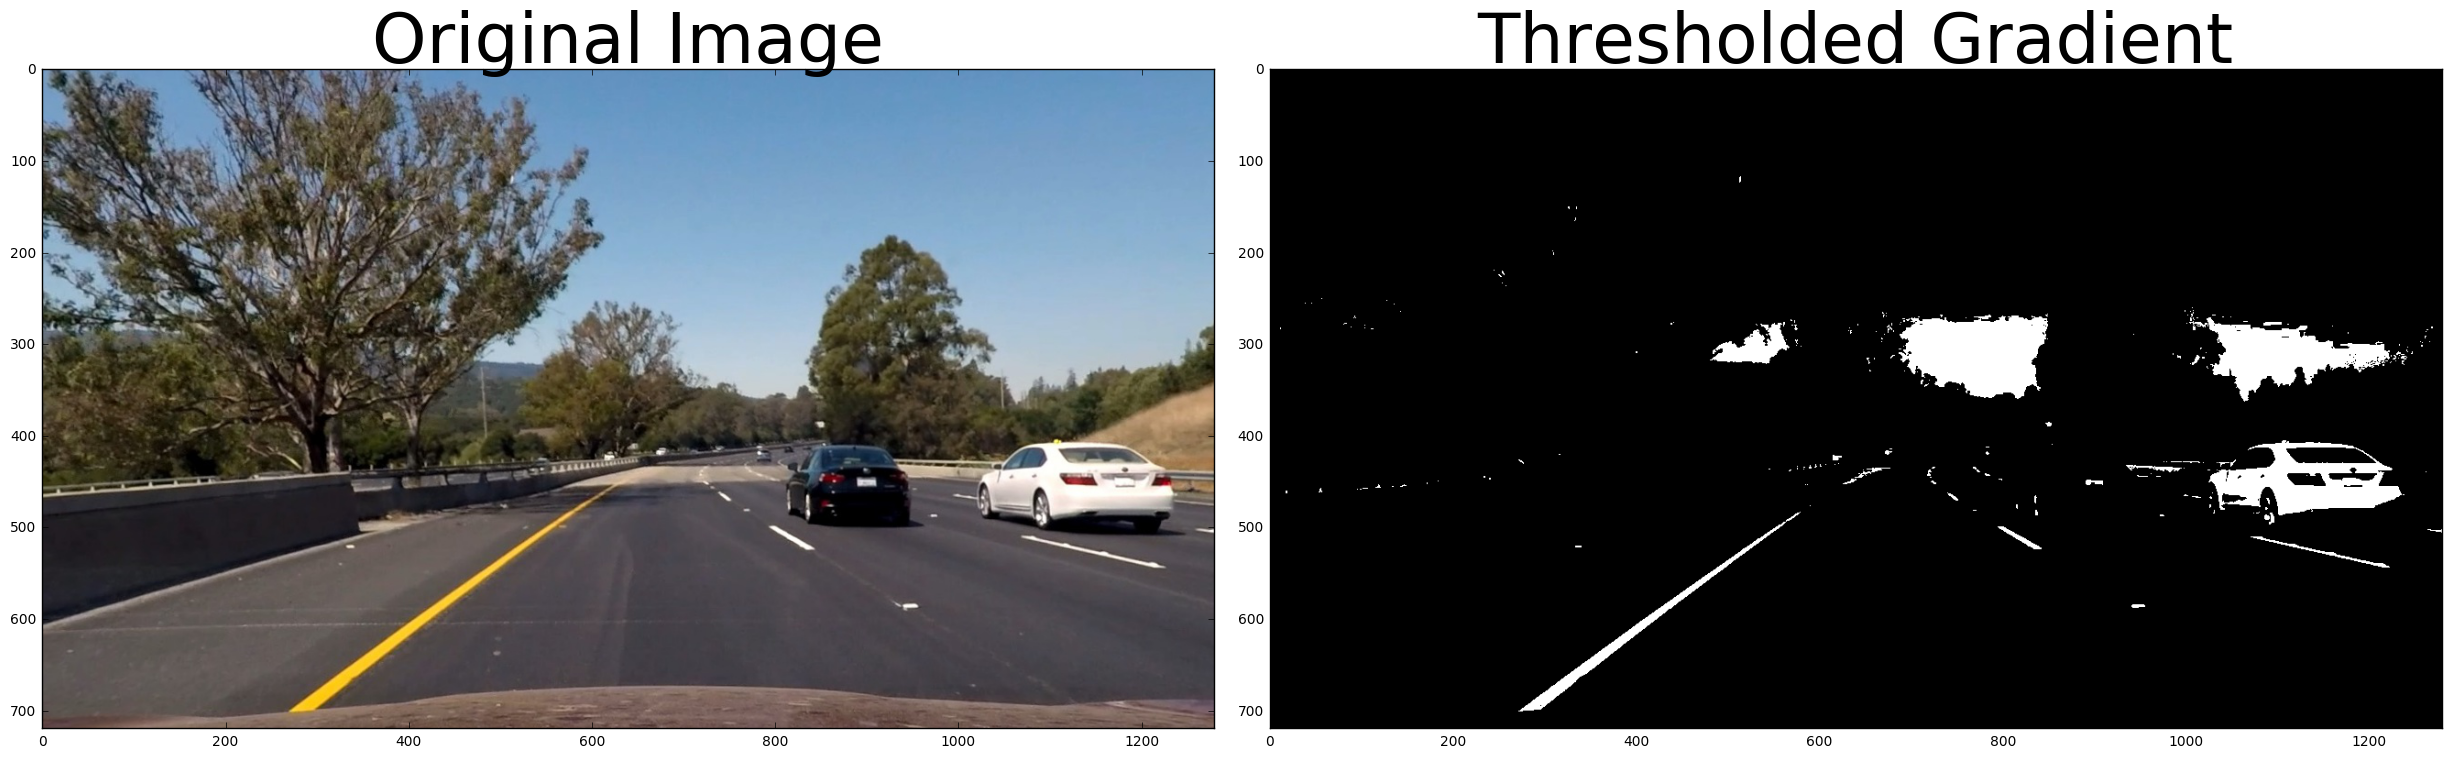

In [39]:
#Read in the image
image = mpimg.imread('test_images/test6.jpg')
#Blur the image
blur_kernel_size = 1
image = gaussian_noise(image, blur_kernel_size)
#Define a mask but only implement it after edge detection dot not be detected
imshape = image.shape
        #vertices = np.array([[(80,imshape[0]),(400, 330), (580, 330), (imshape[1],imshape[0])]], dtype=np.int32)
vertices = np.array([[(160,imshape[0]),(imshape[1]/2-60, imshape[0]/2+90),
                  (imshape[1]/2+100, imshape[0]/2+90), (imshape[1]-20,imshape[0])]], dtype=np.int32)
vertices = np.array([[(160,imshape[0]),(imshape[1]/2-60, imshape[0]/2+90),
                  (imshape[1]/2+100, imshape[0]/2+90), (imshape[1]-20,imshape[0])]], dtype=np.int32)
#image = region_of_interest(image, vertices)
thresh = (190, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print(imshape)

3- I've separated the RGB channels and applied a threshold of "thresh = (220, 255)" to remove the noise and fine the lane lines in the images. I also applied a mask defined by "vertices" to select the lane lines and remove everything else in the image.  
I've determined that the color channel "R" is best in finding the lane lines.

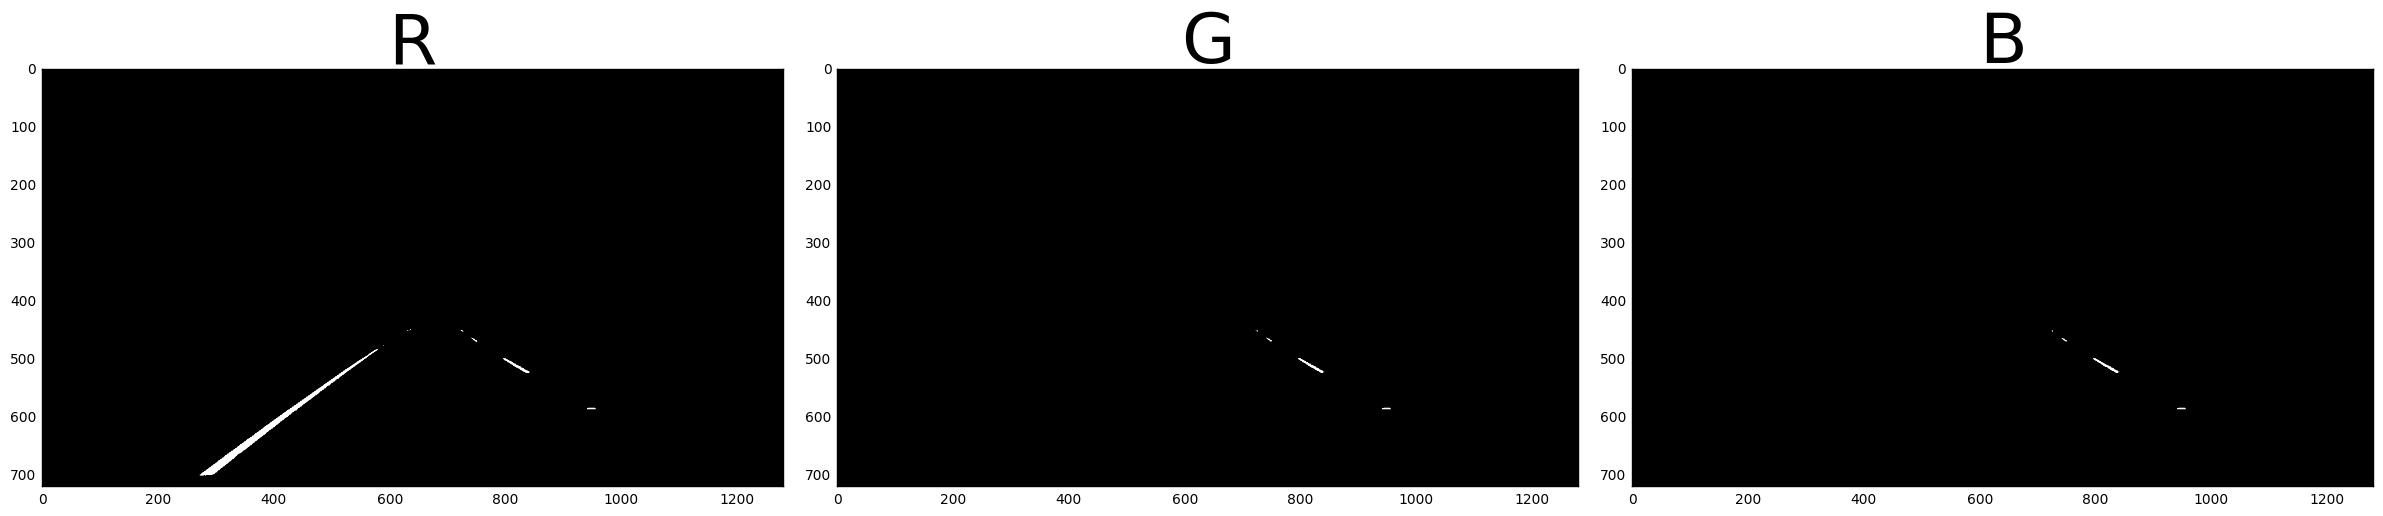

In [40]:
# Splitting RGB Channels
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]
thresh = (220, 255)
#gray_ = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary_R = np.zeros_like(R)
binary_R[(R > thresh[0]) & (R <= thresh[1])] = 1
binary_R= region_of_interest(binary_R, vertices)

binary_G = np.zeros_like(G)
binary_G[(G > thresh[0]) & (G <= thresh[1])] = 1
binary_G= region_of_interest(binary_G, vertices)

binary_B = np.zeros_like(B)
binary_B[(B > thresh[0]) & (B <= thresh[1])] = 1
binary_B= region_of_interest(binary_B, vertices)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_R, cmap='gray')
ax1.set_title('R', fontsize=50)
ax2.imshow(binary_G, cmap='gray')
ax2.set_title('G', fontsize=50)
ax3.imshow(binary_B, cmap='gray')
ax3.set_title('B', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

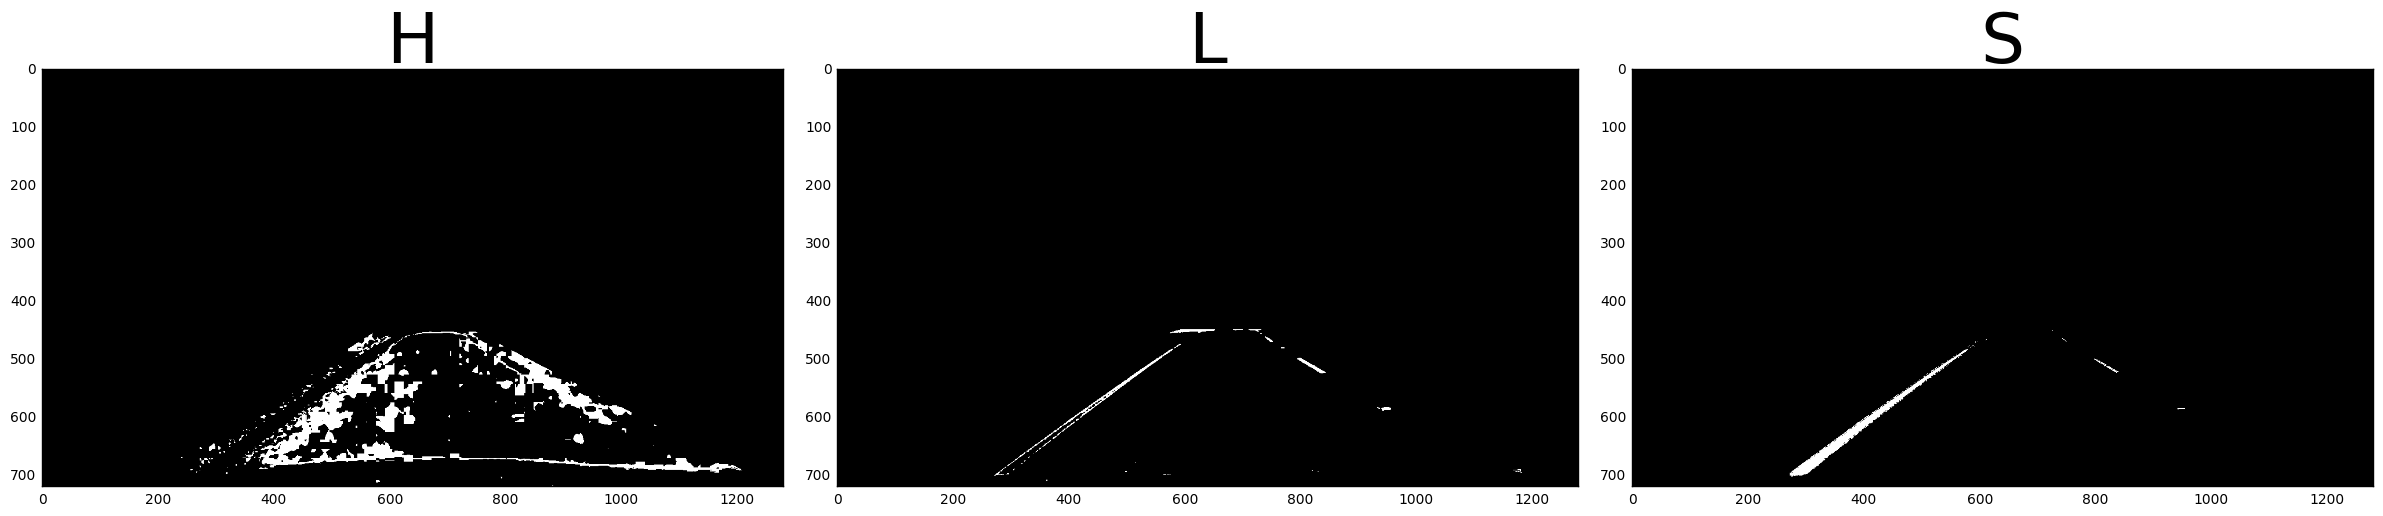

In [41]:
# Splitting HSV Channels
HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

H = HLS[:,:,0]
L = HLS[:,:,1]
S = HLS[:,:,2]
thresh = (150, 255)
#gray_ = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary_H = np.zeros_like(H)
binary_H[(H > thresh[0]) & (H <= thresh[1])] = 1
binary_H= region_of_interest(binary_H, vertices)

binary_L = np.zeros_like(L)
binary_L[(L > thresh[0]) & (L <= thresh[1])] = 1
binary_L= region_of_interest(binary_L, vertices)

binary_S = np.zeros_like(S)
binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1
binary_S= region_of_interest(binary_S, vertices)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_H, cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(binary_L, cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(binary_S, cmap='gray')
ax3.set_title('S', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

5- Edge detection is a widely used method for finding features in images. Here I used Sobel edge detection "cv2.Sobel" using "thresh=(50, 100)" on the thresholded "S" and "R" images as well as the gradient and magnitude threshold images. The figure shows the output where Sobel filter and R channel "Sobel_binary_S" is the best in defining the lane lines.   

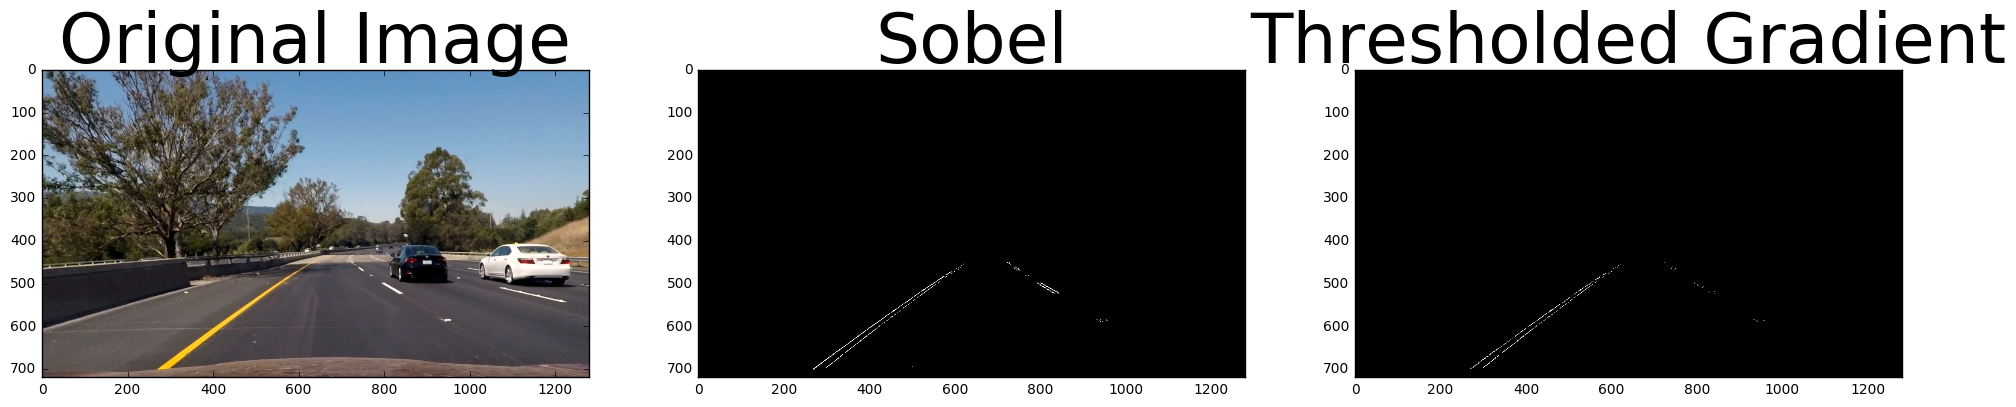

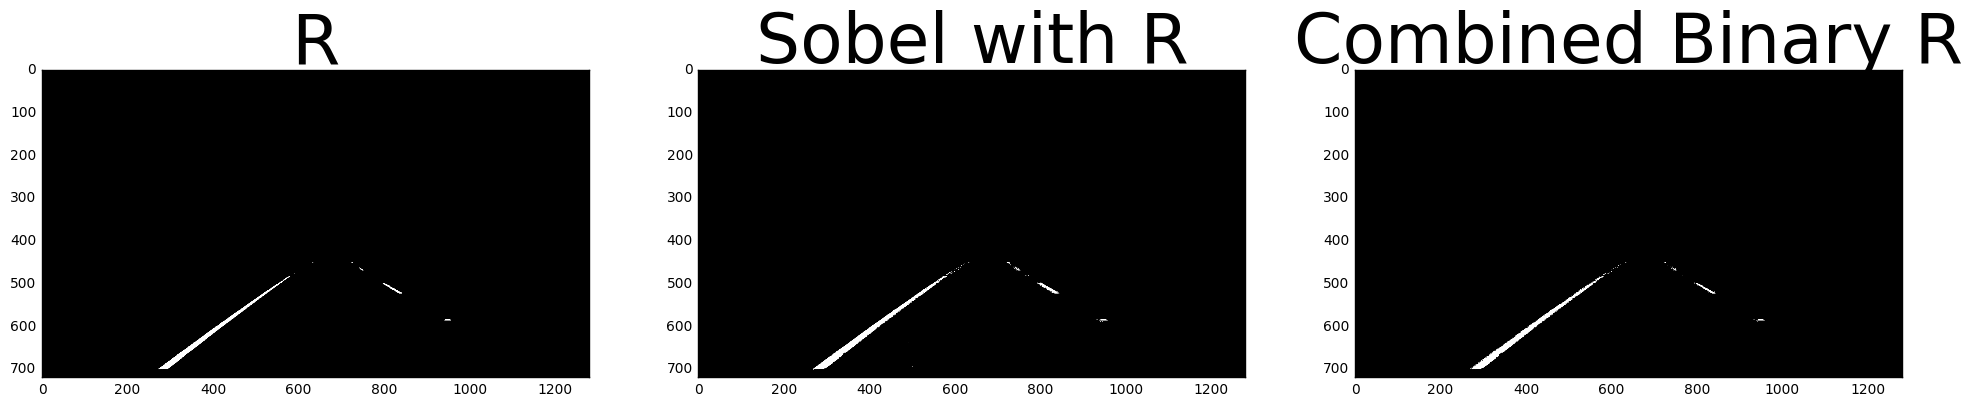

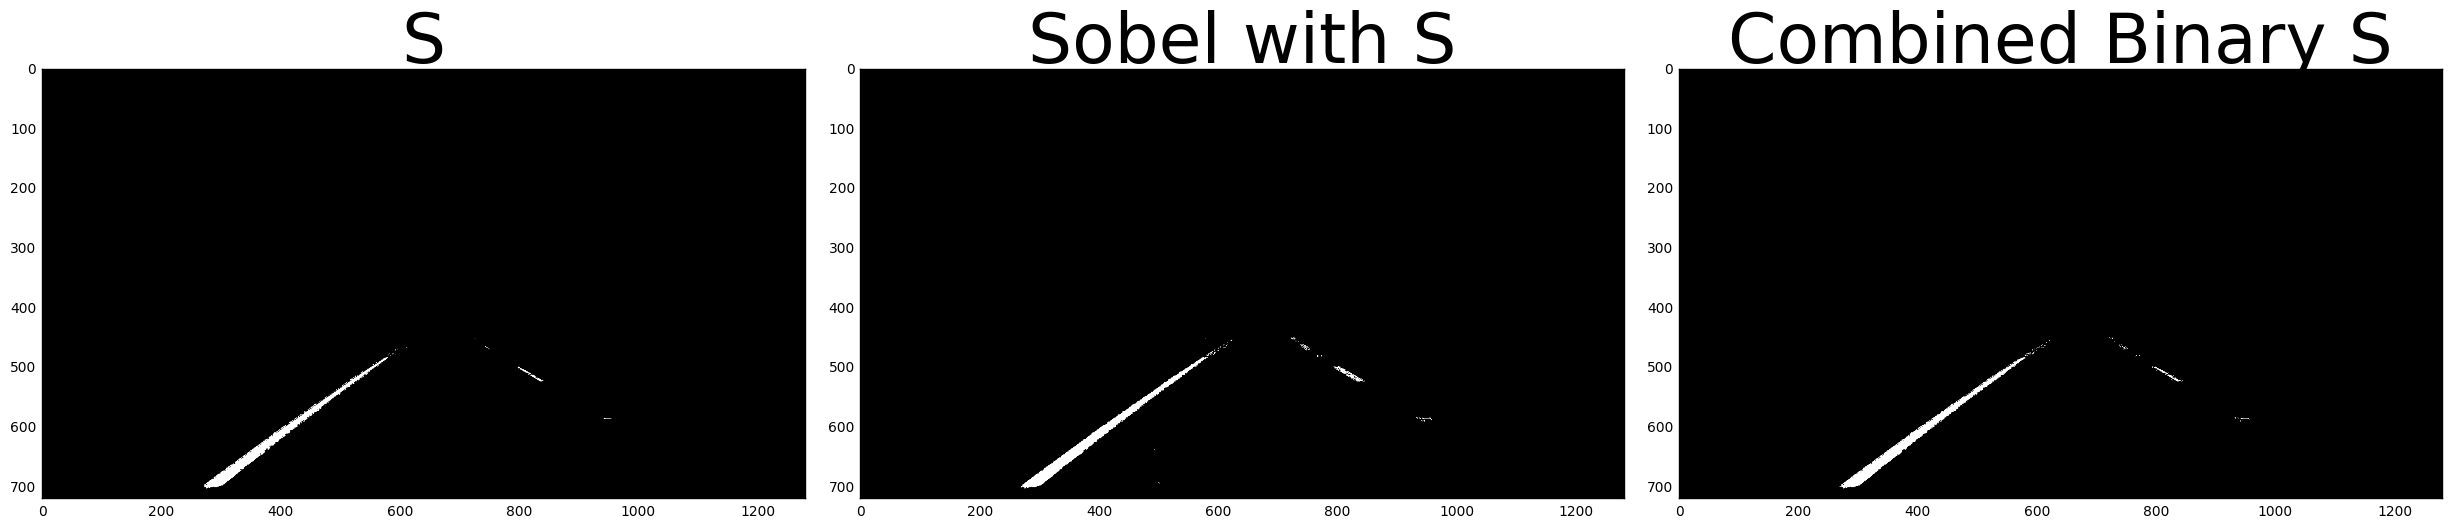

In [42]:
## return sobel threshold
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

## return mag_direction

def mag_thresh(img, sobel_kernel, mag_thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

## return the gradient

def dir_threshold(img, sobel_kernel, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

ksize=3

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 100))
gradx = region_of_interest(gradx, vertices)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 100))
grady = region_of_interest(grady, vertices)
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
mag_binary = region_of_interest(mag_binary, vertices)
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.3, 1.5)) 
dir_binary = region_of_interest(dir_binary, vertices)

#dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


#Combine all combined binary and R channel

combined_binary_R = np.zeros_like(combined )
combined_binary_R[(binary_R== 1) | (combined == 1)] = 1

#color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
#Combine all combined binary and S channel

combined_binary_S = np.zeros_like(combined )
combined_binary_S[(binary_S== 1) | (combined == 1)] = 1

#Combine Sobel and R channel

Sobel_binary_R = np.zeros_like(gradx)
Sobel_binary_R[(binary_R== 1) | (gradx== 1)] = 1

#Combine all combined binary and S channel

Sobel_binary_S = np.zeros_like(gradx )
Sobel_binary_S[(binary_S== 1) | (gradx == 1)] = 1

#Sobel_binary_S = hough_lines(Sobel_binary_S, rho, theta, threshold, min_line_len, max_line_gap)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(24, 9))
f, (ax7, ax8, ax9) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
 
#####
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Sobel', fontsize=50)
ax3.imshow(combined, cmap='gray')
ax3.set_title('Thresholded Gradient', fontsize=50)
#####
#####
ax4.imshow(binary_R, cmap='gray')
ax4.set_title('R', fontsize=50)
ax5.imshow(Sobel_binary_R , cmap='gray')
ax5.set_title('Sobel with R', fontsize=50)
ax6.imshow(combined_binary_R, cmap='gray')
ax6.set_title('Combined Binary R', fontsize=50)
#####
#####
ax7.imshow(binary_S, cmap='gray')
ax7.set_title('S', fontsize=50)
ax8.imshow(Sobel_binary_S , cmap='gray')
ax8.set_title('Sobel with S', fontsize=50)
ax9.imshow(combined_binary_S, cmap='gray')
ax9.set_title('Combined Binary S', fontsize=50)
#####
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective transform
### 3. Has a perspective transform been applied to rectify the image?
Image perceptive transform is the process with which the image is warped in order to be displayed from a different perspective. This process tuned useful in finding the lanelines. "cv2.getPerspectiveTransform" is used for performing the transform by providing the source and destination coordinates "src" and "dst". The figures below show the orginal binary image and the transformed one.

 

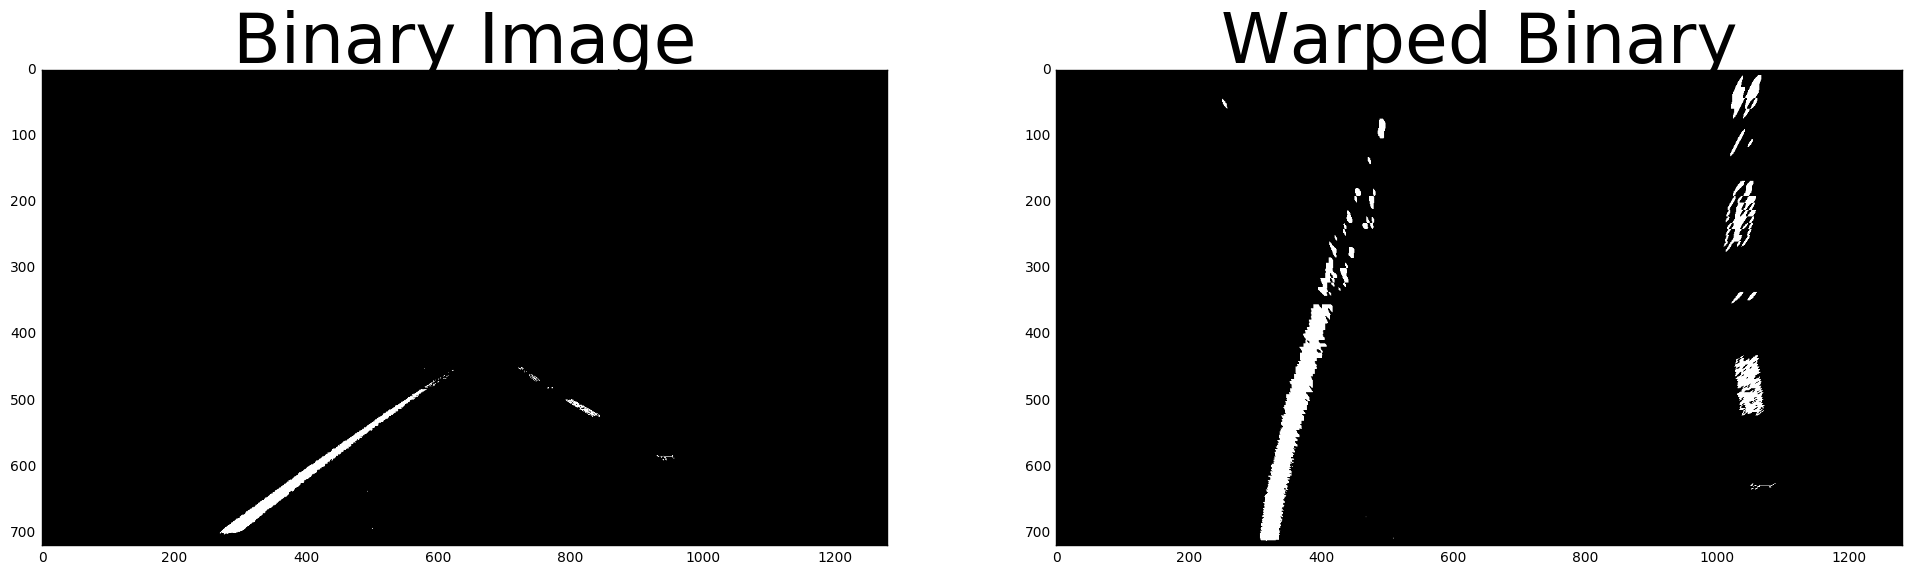

In [43]:
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
Minv, warped_img= transform(Sobel_binary_S)

ax1.imshow(Sobel_binary_S, cmap='gray')
ax1.set_title('Binary Image', fontsize=50)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped Binary', fontsize=50)
 
 

## Locating the Lane Lines and Determine the Curvature

I have explored several methods for locating the lane lines in the images including

1- finding the histogram and applying a moving window to extract the lane lines.

2- finding the corners in the binary images and then covering them into arrays of coordinates

I have implemented a method for finding the histogram by using "np.sum(warped_img[warped_img.shape[0]/2:,:], axis=0)". I will not explain the approach followed for extracting the landlines from the histogram because I have ruled out this approach and used the second method. This decision was made after testing both methods and comparing the results. The code for finding the lanes using the histogram method was commented out below.

 

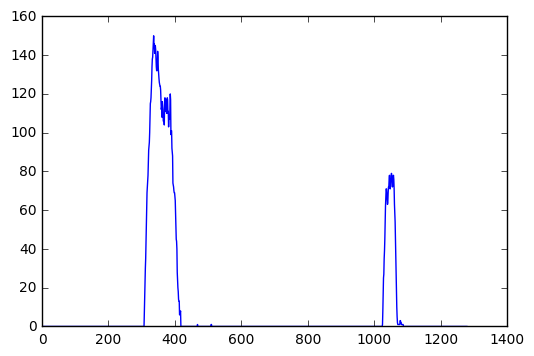

In [44]:

#first take a histogram along all the columns in the lower half of the image like this:
histogram = np.sum(warped_img[warped_img.shape[0]/2:,:], axis=0)
plt.plot(histogram)



In [45]:

# sample histogram of the bottom 40% pixels from a black & white image bw_image
"""
bw_img=warped_img
histogram = np.sum(bw_img[np.int(bw_img.shape[0]*0.6):,:], axis=0)

def lane_centers(h):
    # h is a histogram of lane pixels
    # find the left and right max, which we return
    # as lane centers
    midpoint = np.int(h.shape[0]/2)
    mark_left = np.argmax(h[0:midpoint])
    mark_right = np.argmax(h[midpoint:])+midpoint
    return mark_left, mark_right

def copy_sliding_y_window(src, dst, mid, win_size=80):
    # src contains pixels of potential lane markers
    # dst is an empty image that will receive candidate pixels
    # by sliding a window from "mid"-point, the vertical y coordinate
    # for a potential lane marker.
    for row in range(src.shape[0]-1,0,-1):
        lo = max(0,mid-win_size)
        hi = min(mid+win_size, src.shape[1]-1)
        scan_line = src[row,lo:hi]
        dst[row,lo:hi] = scan_line
        ones = np.where(scan_line == 1)
        if len(ones[0]):
            mid = np.int(np.mean(ones)+lo+0.5)

ml, mr = lane_centers(histogram)
lines = np.zeros_like(bw_img)
copy_sliding_y_window(bw_img, lines, ml)
copy_sliding_y_window(bw_img, lines, mr)
plt.axis('off')
plt.imshow(lines, cmap='gray')
"""

'\nbw_img=warped_img\nhistogram = np.sum(bw_img[np.int(bw_img.shape[0]*0.6):,:], axis=0)\n\ndef lane_centers(h):\n    # h is a histogram of lane pixels\n    # find the left and right max, which we return\n    # as lane centers\n    midpoint = np.int(h.shape[0]/2)\n    mark_left = np.argmax(h[0:midpoint])\n    mark_right = np.argmax(h[midpoint:])+midpoint\n    return mark_left, mark_right\n\ndef copy_sliding_y_window(src, dst, mid, win_size=80):\n    # src contains pixels of potential lane markers\n    # dst is an empty image that will receive candidate pixels\n    # by sliding a window from "mid"-point, the vertical y coordinate\n    # for a potential lane marker.\n    for row in range(src.shape[0]-1,0,-1):\n        lo = max(0,mid-win_size)\n        hi = min(mid+win_size, src.shape[1]-1)\n        scan_line = src[row,lo:hi]\n        dst[row,lo:hi] = scan_line\n        ones = np.where(scan_line == 1)\n        if len(ones[0]):\n            mid = np.int(np.mean(ones)+lo+0.5)\n\nml, mr = la

In the second approach I used Open CV "corner_peaks" and "corner_harris" to find the coordinates of detected lanes in the binary image. This method is better than the histogram method because is less computation demanding, faster, and more accurate in finding the lane lines. It also has "min_distance" attribute that gives me control over the smoothness of found lane lines and reducing noise from other detected objects. 
In order to identify the left and right lane lines, I applied a mask to divide the image into two equal regions and then computed "Harris" corner finding on each part separately. "corners_l" and "corners_r" are the two arrays containing the tuples for (x,y) coordinates in the left and right images. 

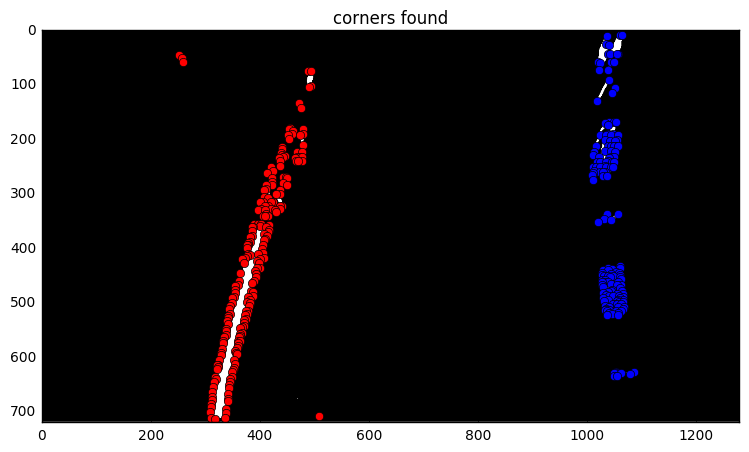

Number of left corners: 207 Number of right corners: 155


In [46]:

## define the left and right lane 
#Find the corners in the image and find their x and y coordinates. 
#warped_img = lines
row_w,col_w=warped_img.shape
warped_img_left=warped_img[0:row_w,0:math.ceil(col_w/2)]
warped_img_right=warped_img[0:row_w,math.ceil(col_w/2):col_w]
def show_corners(corners_l, corners_r,image,title=None):
    """Display a list of corners overlapping an image"""
    fig = plt.figure()
    plt.imshow(image,cmap='gray')
    y_corner_l,x_corner_l = zip(*corners_l)
    y_corner_r,x_corner_r = zip(*corners_r)
    plt.plot(x_corner_l,y_corner_l,'ro') # Plot corners
    plt.plot(x_corner_r,y_corner_r,'bo') # Plot corners
    if title:
        plt.title(title)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0],0) # Images use weird axes
    fig.set_size_inches(np.array(fig.get_size_inches()) * 1.5)
    plt.show()
    print ("Number of left corners:",len(corners_l),"Number of right corners:",len(corners_r), )    
corners_left = corner_peaks(corner_harris(warped_img_left),min_distance=2)
corners_right = corner_peaks(corner_harris(warped_img_right),min_distance=2)
show_corners(corners_left,corners_right+[0,math.ceil(col_w/2)],warped_img,title="corners found")    


    
 

## Radius of curvature finding, interpolation and extrapolation

### 4. Have lane line pixels been identified in the rectified image and fit with a polynomial?

A second order polynomial is used to find the lane lines as accurately as possible with "polyfit". However, the output line extends only to the detected lane lines and sometimes doesn't pass through the entire masked image. Therefore the line is extrapolated by defining the min and max points in the y direction. The figure below shown a plot of the identified corners and the polynomial passing through them.
To find the curvature I've estimated 30/720  meters per pixel in y dimension and 3.7/700  meters per pixel in x dimension using the recommendations from the course materials.  Based on that I have also estimated the position of the car using “center = abs(640 – ((rightx_int+leftx_int)/2)*3.7/700)”. 
Further smoothing was carried out by averaging the polynomials in the pipeline that was used to output the video.

2379.18843058 2662.61068907
2078.34520843 m 1822.39432559 m


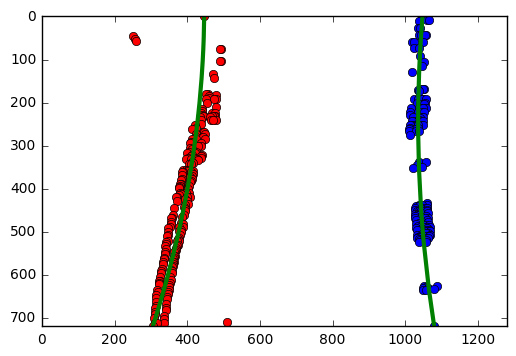

In [54]:
y_corner_l,x_corner_l = zip(*corners_left)
adjusted_corners_right= corners_right+[0,math.ceil(col_w/2)]                                    
y_corner_r,x_corner_r = zip(*adjusted_corners_right)
#Measuring Curvature
yvalus = warped_img.shape[0]
#Represent lane-line pixels
leftx = np.array(x_corner_l)
lefty = np.array(y_corner_l)
rightx = np.array(x_corner_r)
righty = np.array(y_corner_r)
# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
#Extrapolation fit the line in top and bottom
right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
rightx = np.append(rightx,rightx_int)
righty = np.append(righty, 720)
rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
righty = np.append(righty, 0)
leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
leftx = np.append(leftx, leftx_int)
lefty = np.append(lefty, 720)
leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
lefty = np.append(lefty, 0)
lsort = np.argsort(lefty)
rsort = np.argsort(righty)
lefty = lefty[lsort]
leftx = leftx[lsort]
righty = righty[rsort]
rightx = rightx[rsort]
left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
########
plt.plot(leftx, lefty, 'o', color='red')
plt.plot(rightx, righty, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, lefty, color='green', linewidth=3)
plt.plot(right_fitx, righty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval_l = np.max(700)
y_eval_r = np.max(700)
left_curverad = ((1 + (2*left_fit[0]*y_eval_l + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval_r + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_l + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_r + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
center = abs((640 - ((rightx_int+leftx_int)/2))*3.7/700)    
          # Calculate the position of the vehicle
## Radius of curvature finding, interpolation and extrapolation

              # Calculate the position of the vehicle

img_size = (img.shape[1], img.shape[0])    
    # Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m
                   

### 5. Having identified the lane lines, has the radius of curvature of the road been estimated? And the position of the vehicle with respect to center in the lane?

Yes, the results are shown in the image below.

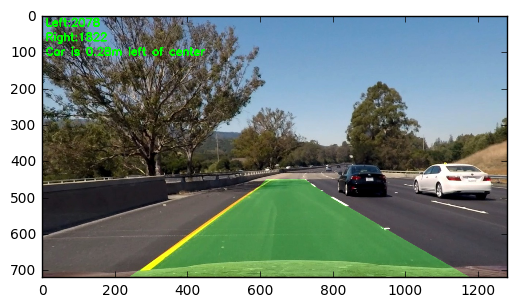

In [55]:
#Drawing the lines back down onto the road
#mage called warped, and you have fit the lines with a polynomial and have arrays called yvals, 
#left_fitx and right_fitx, 
img_size = (img.shape[1], img.shape[0])
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, lefty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, righty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
final_result=cv2.putText(result, "Left:{}".format(math.floor(left_curverad)),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
final_result=cv2.putText(result, "Right:{}".format(math.floor(right_curverad)),(10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
if center < 640:
        final_result=cv2.putText(result, "Car is {:.2f}m left of center".format(center),(10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
else:
        final_result=cv2.putText(result, "Car is {:.2f}m right of center".format(center),(10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)

plt.imshow(final_result)

## Pipeline (video)
### 1. Does the pipeline established with the test images work to process the video?

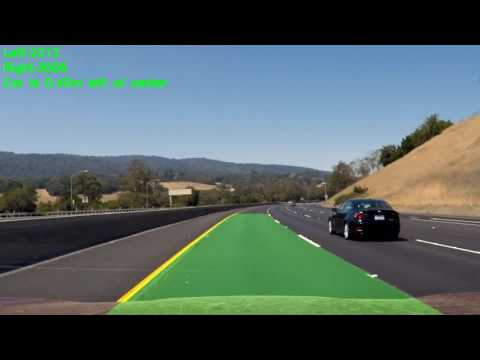

In [60]:
from IPython.display import YouTubeVideo

YouTubeVideo('AxW5w1kI6Hw')

## README

### 1. Has a README file been included that describes in detail the steps taken to construct the pipeline, techniques used, areas where improvements could be made?

You're reading it!